In [239]:
!pip install transformers

In [240]:
# This should be edited if the notebook is not in Colab

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the tweet datase
path_to_tweets_data = '/content/drive/MyDrive/tweets_data_labeled.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [241]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

In [242]:
# Read the tweet dataset
# A small portion in the head of this dataset is already labeled by its creators, but rest is not
tweet_data = pd.read_csv(path_to_tweets_data, delimiter=";")
tweet_data

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...,...
4995,411380,2020-06-04 18:14:57+00:00,"With ad revenues falling, what’s the impact on...",NaN
4996,62318,2020-04-14 02:15:01+00:00,RT @KelvinSCWong: Well another point to add to...,NaN
4997,627230,2020-06-23 14:08:15+00:00,$ITOX working on a contract with a fortune 500...,NaN
4998,890123,2020-07-14 23:18:34+00:00,"$DIS it could break the 120 pin, then 125&gt; ...",NaN


In [243]:
# Sort by date
tweet_data = tweet_data.sort_values('created_at')
tweet_data

,id,created_at,text,sentiment
236,14135,2020-04-09 00:00:03+00:00,"$HEXO target price is $2.21, HEXO has a upside...",positive
1700,13977,2020-04-09 00:20:44+00:00,You have the news: Disney+ Hits 50 Million Pai...,NaN
3007,13633,2020-04-09 01:02:35+00:00,RT @awallenstein: BREAKING: Disney+ reaches 50...,NaN
3028,13563,2020-04-09 01:11:26+00:00,RT @RichLightShed: With 50 million subs and gr...,NaN
1404,13267,2020-04-09 01:49:10+00:00,RT @thechartist: The $SPX recovering extremely...,NaN
...,...,...,...,...
344,925662,2020-07-16 21:03:01+00:00,Watching Mark Zuckerberg interview Dr. Fauci o...,neutral
2017,925548,2020-07-16 21:15:54+00:00,Looks like $DIS investors don't know how to th...,NaN
3163,925537,2020-07-16 21:16:42+00:00,RT @WallStSupp: NEW SHIRT ALERT:\n\nShow some ...,NaN
4794,924598,2020-07-16 23:16:23+00:00,"@scttyd47 It's definitely a possibility, and q...",NaN


In [244]:
# Initialize NLP model
from transformers import pipeline
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [245]:
# Labeling the tweet data
tweet_data_labeled_path = '/content/drive/MyDrive/tweet_data_completely_labeled.csv'
has_labeled_tweet_data = True
if not has_labeled_tweet_data:
    print('Creating the labels for tweet data')
    # Create sentiments for the tweet data and save its updated version
    sentiments = sentiment_task(tweet_data['text'].values.tolist())
    labels = [item['label'] for item in sentiments]
    tweet_data['sentiment'] = labels
    tweet_data.to_csv(tweet_data_labeled_path)
    tweet_data = tweet_data.drop(['id'], axis=1)
else:
    print('Reading from the saved version')
    tweet_data = pd.read_csv(tweet_data_labeled_path)
    tweet_data = tweet_data.drop(['Unnamed: 0', 'id'], axis=1)
tweet_data.rename(columns = {'created_at':'Date'}, inplace = True)
tweet_data['Date'] = [d[:10] for d in tweet_data['Date'].values.tolist()]
tweet_data = tweet_data.set_index('Date')
tweet_data

Reading from the saved version


,text,sentiment
Date,,
2020-04-09,"$HEXO target price is $2.21, HEXO has a upside...",positive
2020-04-09,You have the news: Disney+ Hits 50 Million Pai...,positive
2020-04-09,RT @awallenstein: BREAKING: Disney+ reaches 50...,positive
2020-04-09,RT @RichLightShed: With 50 million subs and gr...,neutral
2020-04-09,RT @thechartist: The $SPX recovering extremely...,positive
...,...,...
2020-07-16,Watching Mark Zuckerberg interview Dr. Fauci o...,neutral
2020-07-16,Looks like $DIS investors don't know how to th...,neutral
2020-07-16,RT @WallStSupp: NEW SHIRT ALERT:\n\nShow some ...,positive


In [246]:
# Read the finance data from Yahoo Finance
tickers = ['AAPL', 'TSLA', 'AMZN']
finance_data = yf.download(tickers,'2020-04-10','2022-07-15', auto_adjust=True)['Close']
finance_data

[*********************100%%**********************]  3 of 3 completed


,AAPL,AMZN,TSLA
Date,,,
2020-04-13,66.798050,108.443497,43.396667
2020-04-14,70.171562,114.166000,47.326000
2020-04-15,69.531105,115.384003,48.655334
2020-04-16,70.083572,120.409500,49.680668
2020-04-17,69.132629,118.750000,50.259335
...,...,...,...
2022-07-08,145.970093,115.540001,250.763336
2022-07-11,143.815872,111.750000,234.343338
2022-07-12,144.798676,109.220001,233.070007


In [247]:
# Which stocks are mentioned in the tweets?
tweet_data['AAPL'] = [(1 if 'AAPL' in tweet else 0) for tweet in tweet_data['text'].values.tolist()]
tweet_data['AMZN'] = [(1 if 'AMZN' in tweet else 0) for tweet in tweet_data['text'].values.tolist()]
tweet_data['TSLA'] = [(1 if 'TSLA' in tweet else 0) for tweet in tweet_data['text'].values.tolist()]
tweet_data

,text,sentiment,AAPL,AMZN,TSLA
Date,,,,,
2020-04-09,"$HEXO target price is $2.21, HEXO has a upside...",positive,0,1,1
2020-04-09,You have the news: Disney+ Hits 50 Million Pai...,positive,1,0,1
2020-04-09,RT @awallenstein: BREAKING: Disney+ reaches 50...,positive,0,0,0
2020-04-09,RT @RichLightShed: With 50 million subs and gr...,neutral,0,0,0
2020-04-09,RT @thechartist: The $SPX recovering extremely...,positive,0,0,0
...,...,...,...,...,...
2020-07-16,Watching Mark Zuckerberg interview Dr. Fauci o...,neutral,0,0,0
2020-07-16,Looks like $DIS investors don't know how to th...,neutral,0,0,0
2020-07-16,RT @WallStSupp: NEW SHIRT ALERT:\n\nShow some ...,positive,0,0,0


In [248]:
# Make sentiment numeric (-1, 0, 1)
tweet_data['sentiment'] = tweet_data['sentiment'].map(
    {'positive': 1, 'neutral': 0, 'negative': -1})
tweet_data

,text,sentiment,AAPL,AMZN,TSLA
Date,,,,,
2020-04-09,"$HEXO target price is $2.21, HEXO has a upside...",1,0,1,1
2020-04-09,You have the news: Disney+ Hits 50 Million Pai...,1,1,0,1
2020-04-09,RT @awallenstein: BREAKING: Disney+ reaches 50...,1,0,0,0
2020-04-09,RT @RichLightShed: With 50 million subs and gr...,0,0,0,0
2020-04-09,RT @thechartist: The $SPX recovering extremely...,1,0,0,0
...,...,...,...,...,...
2020-07-16,Watching Mark Zuckerberg interview Dr. Fauci o...,0,0,0,0
2020-07-16,Looks like $DIS investors don't know how to th...,0,0,0,0
2020-07-16,RT @WallStSupp: NEW SHIRT ALERT:\n\nShow some ...,1,0,0,0


In [249]:
# Project sentiment on top of the stocks
tweet_data['AAPL'] = tweet_data['AAPL'] * tweet_data['sentiment']
tweet_data['AMZN'] = tweet_data['AMZN'] * tweet_data['sentiment']
tweet_data['TSLA'] = tweet_data['TSLA'] * tweet_data['sentiment']
tweet_data = tweet_data.drop('sentiment', axis=1)
tweet_data

,text,AAPL,AMZN,TSLA
Date,,,,
2020-04-09,"$HEXO target price is $2.21, HEXO has a upside...",0,1,1
2020-04-09,You have the news: Disney+ Hits 50 Million Pai...,1,0,1
2020-04-09,RT @awallenstein: BREAKING: Disney+ reaches 50...,0,0,0
2020-04-09,RT @RichLightShed: With 50 million subs and gr...,0,0,0
2020-04-09,RT @thechartist: The $SPX recovering extremely...,0,0,0
...,...,...,...,...
2020-07-16,Watching Mark Zuckerberg interview Dr. Fauci o...,0,0,0
2020-07-16,Looks like $DIS investors don't know how to th...,0,0,0
2020-07-16,RT @WallStSupp: NEW SHIRT ALERT:\n\nShow some ...,0,0,0


In [250]:
# Creating a joint dataset for the cause from both finance data and the tweets data
dates_of_tweets = list(dict.fromkeys(tweet_data.index.tolist()))
dates_of_stocks = [str(s)[:10] for s in list(dict.fromkeys(finance_data.index.tolist()))]
intersection_dates = sorted(list(set(dates_of_tweets) & set(dates_of_stocks)))
joint_data = finance_data[finance_data.index.isin(intersection_dates)].copy(deep=True)
for s in tickers:
    temp = []
    for d in intersection_dates:
        dt = tweet_data[tweet_data.index == d]
        if dt[s].sum() > 0:
            temp.append(1)
        elif dt[s].sum() < 0:
            temp.append(-1)
        else:
            temp.append(0)
    joint_data[s+'_sentiment'] = temp
joint_data

,AAPL,AMZN,TSLA,AAPL_sentiment,TSLA_sentiment,AMZN_sentiment
Date,,,,,,
2020-04-13,66.798050,108.443497,43.396667,-1,1,0
2020-04-14,70.171562,114.166000,47.326000,1,0,1
2020-04-15,69.531105,115.384003,48.655334,1,0,0
2020-04-16,70.083572,120.409500,49.680668,1,1,1
2020-04-17,69.132629,118.750000,50.259335,1,0,1
2020-04-20,67.697662,119.680496,49.757332,1,0,0
2020-04-21,65.605103,116.405998,45.781334,1,1,1
2020-04-22,67.494774,118.174500,48.807335,1,1,1
2020-04-23,67.233200,119.972504,47.042000,1,1,1


In [251]:
# Add ground truth labels to the data for the training
# The labels corresponds to will go up and will go down respectively for '-1' and '1'
# Since it is daily predictions, the class that corresponds to 'almost no change' coded with '0' is eliminated
# Because the changes are always not too big on a daily basis
joint_data['AAPL_label'] = joint_data['AAPL'].pct_change()
joint_data['AAPL_label'] = joint_data['AAPL_label'].apply(lambda x: 1 if x >= 0 else -1)
joint_data['AMZN_label'] = joint_data['AMZN'].pct_change()
joint_data['AMZN_label'] = joint_data['AMZN_label'].apply(lambda x: 1 if x >= 0 else -1)
joint_data['TSLA_label'] = joint_data['TSLA'].pct_change()
joint_data['TSLA_label'] = joint_data['TSLA_label'].apply(lambda x: 1 if x >= 0 else -1)
joint_data = joint_data.drop('2020-04-13') # Drop the first row since it cannot be labeled
joint_data

,AAPL,AMZN,TSLA,AAPL_sentiment,TSLA_sentiment,AMZN_sentiment,AAPL_label,AMZN_label,TSLA_label
Date,,,,,,,,,
2020-04-14,70.171562,114.166000,47.326000,1,0,1,1,1,1
2020-04-15,69.531105,115.384003,48.655334,1,0,0,-1,1,1
2020-04-16,70.083572,120.409500,49.680668,1,1,1,1,1,1
2020-04-17,69.132629,118.750000,50.259335,1,0,1,-1,-1,1
2020-04-20,67.697662,119.680496,49.757332,1,0,0,-1,1,-1
2020-04-21,65.605103,116.405998,45.781334,1,1,1,-1,-1,-1
2020-04-22,67.494774,118.174500,48.807335,1,1,1,1,1,1
2020-04-23,67.233200,119.972504,47.042000,1,1,1,-1,1,-1
2020-04-24,69.174194,120.511002,48.343334,1,0,1,1,1,1


In [252]:
# Train-Test Split
train_joint_data = joint_data.iloc[:((joint_data.shape[0]//3)*2),:]
test_joint_data = joint_data.iloc[((joint_data.shape[0]//3)*2):,:]

In [253]:
# Separate the stocks
# AAPL
X_train_AAPL = train_joint_data[['AAPL', 'AAPL_sentiment']].to_numpy()
Y_train_AAPL = train_joint_data['AAPL_label'].to_numpy()
# AMZN
X_train_AMZN = train_joint_data[['AMZN', 'AMZN_sentiment']].to_numpy()
Y_train_AMZN = train_joint_data['AMZN_label'].to_numpy()
# TSLA
X_train_TSLA = train_joint_data[['TSLA', 'TSLA_sentiment']].to_numpy()
Y_train_TSLA = train_joint_data['TSLA_label'].to_numpy()

In [254]:
# Incorporating Timesteps & Reshaping the data for the LSTM
# AAPL
X_train = []
y_train = []
for i in range(5, X_train_AAPL.shape[0]):
    X_train.append(X_train_AAPL[i-5:i])
    y_train.append(Y_train_AAPL[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 5, 2))
X_train_AAPL, Y_train_AAPL = X_train, y_train
# AMZN
X_train = []
y_train = []
for i in range(5, X_train_AMZN.shape[0]):
    X_train.append(X_train_AMZN[i-5:i])
    y_train.append(Y_train_AMZN[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 5, 2))
X_train_AMZN, Y_train_AMZN = X_train, y_train
# TSLA
X_train = []
y_train = []
for i in range(5, X_train_TSLA.shape[0]):
    X_train.append(X_train_TSLA[i-5:i])
    y_train.append(Y_train_TSLA[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], 5, 2))
X_train_TSLA, Y_train_TSLA = X_train, y_train

In [296]:
# AAPL MODEL

# Set seeds for reproducibility
seed = 23
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelAAPL = Sequential()
modelAAPL.add(LSTM(16, input_shape=(X_train_AAPL.shape[1], X_train_AAPL.shape[2])))
modelAAPL.add(Dense(8, activation='relu'))
modelAAPL.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)
modelAAPL.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_AAPL/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyAAPL = modelAAPL.fit(X_train_AAPL, y_train_encoded, epochs=20, batch_size=2)

Epoch 1/20
15/15 [==============================] - 4s 3ms/step - loss: 0.7020 - accuracy: 0.2759  
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 0.7010 - accuracy: 0.2759
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.2759
Epoch 4/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6993 - accuracy: 0.2759
Epoch 5/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6986 - accuracy: 0.2759
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6976 - accuracy: 0.2759
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6967 - accuracy: 0.2759
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6959 - accuracy: 0.2759
Epoch 9/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.2759
Epoch 10/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.3103
Epoch 11/20
15/15

In [316]:
# AMZN MODEL

# Set seeds for reproducibility
seed = 2
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelAMZN = Sequential()
modelAMZN.add(LSTM(16, input_shape=(X_train_AMZN.shape[1], X_train_AMZN.shape[2])))
modelAMZN.add(Dense(8, activation='relu'))
modelAMZN.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelAMZN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_AMZN/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyAMZN = modelAMZN.fit(X_train_AMZN, y_train_encoded, epochs=30, batch_size=2)

Epoch 1/30
15/15 [==============================] - 4s 7ms/step - loss: 0.7889 - accuracy: 0.2069
Epoch 2/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7849 - accuracy: 0.2069
Epoch 3/30
15/15 [==============================] - 0s 6ms/step - loss: 0.7815 - accuracy: 0.2069
Epoch 4/30
15/15 [==============================] - 0s 6ms/step - loss: 0.7775 - accuracy: 0.2069
Epoch 5/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7742 - accuracy: 0.2069
Epoch 6/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7704 - accuracy: 0.2069
Epoch 7/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7670 - accuracy: 0.2069
Epoch 8/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7629 - accuracy: 0.2069
Epoch 9/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7598 - accuracy: 0.2069
Epoch 10/30
15/15 [==============================] - 0s 5ms/step - loss: 0.7558 - accuracy: 0.2069
Epoch 11/30
15/15 [

In [349]:
# TSLA MODEL

# Set seeds for reproducibility
seed = 12341
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelTSLA = Sequential()
modelTSLA.add(LSTM(16, input_shape=(X_train_TSLA.shape[1], X_train_TSLA.shape[2])))
modelTSLA.add(Dense(8, activation='relu'))
modelTSLA.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-7)
modelTSLA.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_TSLA/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyTSLA = modelTSLA.fit(X_train_TSLA, y_train_encoded, epochs=80, batch_size=2)

Epoch 1/80
15/15 [==============================] - 2s 4ms/step - loss: 0.6944 - accuracy: 0.4138 
Epoch 2/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 3/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 4/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 5/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 6/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 7/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4138
Epoch 8/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4483
Epoch 9/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6944 - accuracy: 0.4483
Epoch 10/80
15/15 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4483
Epoch 11/80
15/15 

In [258]:
# Create X_tests and Y_tests
# AAPL
X_test_AAPL = test_joint_data[['AAPL', 'AAPL_sentiment']].to_numpy()
Y_test_AAPL = test_joint_data['AAPL_label'].to_numpy()
# AMZN
X_test_AMZN = test_joint_data[['AMZN', 'AMZN_sentiment']].to_numpy()
Y_test_AMZN = test_joint_data['AMZN_label'].to_numpy()
# TSLA
X_test_TSLA = test_joint_data[['TSLA', 'TSLA_sentiment']].to_numpy()
Y_test_TSLA = test_joint_data['TSLA_label'].to_numpy()
# AAPL
X_test = []
Y_test = []
for i in range(5, X_test_AAPL.shape[0]):
    X_test.append(X_test_AAPL[i-5:i])
    Y_test.append(Y_test_AAPL[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], 5, 2))
X_test_AAPL, Y_test_AAPL = X_test, Y_test
# AMZN
X_test = []
Y_test = []
for i in range(5, X_test_AMZN.shape[0]):
    X_test.append(X_test_AMZN[i-5:i])
    Y_test.append(Y_test_AMZN[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], 5, 2))
X_test_AMZN, Y_test_AMZN = X_test, Y_test
# TSLA
X_test = []
Y_test = []
for i in range(5, X_test_TSLA.shape[0]):
    X_test.append(X_test_TSLA[i-5:i])
    Y_test.append(Y_test_TSLA[i])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], 5, 2))
X_test_TSLA, Y_test_TSLA = X_test, Y_test

In [297]:
# Evaluate model on AAPL test set
print("EVALUATION ON TEST DATA of AAPL")
# Convert labels to one-hot encoding
Y_test_AAPL_encoded = to_categorical(Y_test_AAPL/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelAAPL.evaluate(X_test_AAPL, Y_test_AAPL_encoded)

EVALUATION ON TEST DATA of AAPL
1/1 [==============================] - 0s 357ms/step - loss: 0.6877 - accuracy: 0.6667


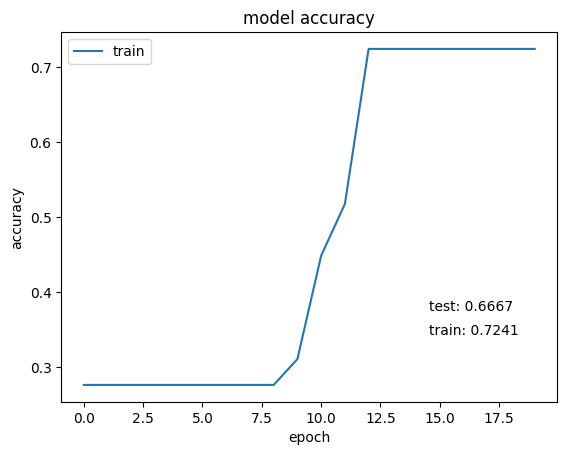

In [298]:
# AAPL Graph
plt.plot(historyAAPL.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyAAPL.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [317]:
# Evaluate model on AMZN test set
print("EVALUATION ON TEST DATA of AMZN")
# Convert labels to one-hot encoding
Y_test_AMZN_encoded = to_categorical(Y_test_AMZN/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelAMZN.evaluate(X_test_AMZN, Y_test_AMZN_encoded)

EVALUATION ON TEST DATA of AMZN
1/1 [==============================] - 1s 610ms/step - loss: 0.6858 - accuracy: 0.5833


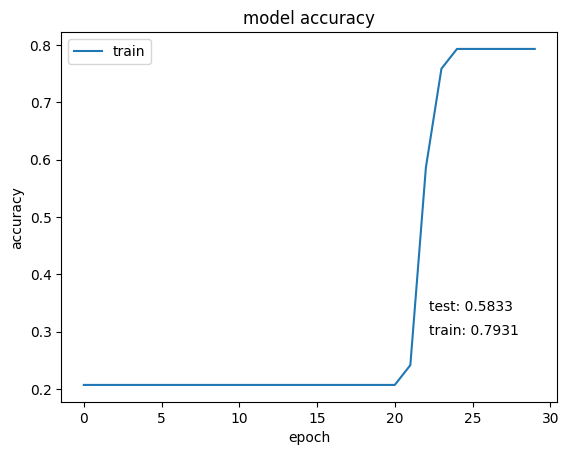

In [318]:
# AMZN Graph
plt.plot(historyAMZN.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyAMZN.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [350]:
# Evaluate model on TSLA test set
print("EVALUATION ON TEST DATA of TSLA")
# Convert labels to one-hot encoding
Y_test_TSLA_encoded = to_categorical(Y_test_TSLA/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelTSLA.evaluate(X_test_TSLA, Y_test_TSLA_encoded)

EVALUATION ON TEST DATA of TSLA
1/1 [==============================] - 1s 576ms/step - loss: 0.6903 - accuracy: 0.7500


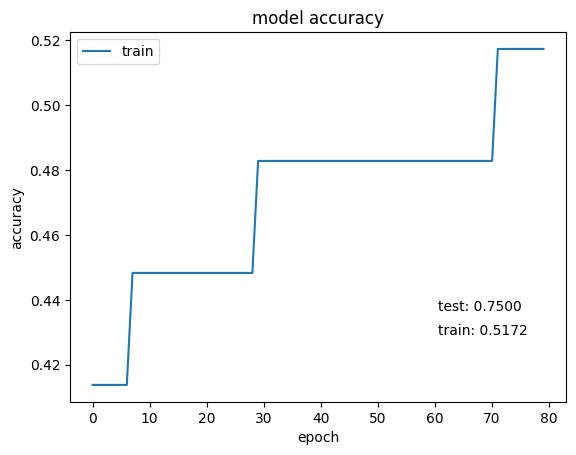

In [351]:
# TSLA Graph
plt.plot(historyTSLA.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyTSLA.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [352]:
# How about only with the stock prices?
X_train_AAPL = X_train_AAPL[:,:,:1]
X_train_AMZN = X_train_AMZN[:,:,:1]
X_train_TSLA = X_train_TSLA[:,:,:1]

In [353]:
# AAPL MODEL

# Set seeds for reproducibility
seed = 23
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelAAPL = Sequential()
modelAAPL.add(LSTM(16, input_shape=(X_train_AAPL.shape[1], X_train_AAPL.shape[2])))
modelAAPL.add(Dense(8, activation='relu'))
modelAAPL.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)
modelAAPL.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_AAPL/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyAAPL = modelAAPL.fit(X_train_AAPL, y_train_encoded, epochs=20, batch_size=2)

Epoch 1/20
15/15 [==============================] - 2s 3ms/step - loss: 0.7018 - accuracy: 0.2759 
Epoch 2/20
15/15 [==============================] - 0s 2ms/step - loss: 0.7008 - accuracy: 0.2759
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.2759
Epoch 4/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6991 - accuracy: 0.2759
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6985 - accuracy: 0.2759
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.2759
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6966 - accuracy: 0.2759
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.2759
Epoch 9/20
15/15 [==============================] - 0s 3ms/step - loss: 0.6949 - accuracy: 0.2759
Epoch 10/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.2759
Epoch 11/20
15/15 

In [354]:
# AMZN MODEL

# Set seeds for reproducibility
seed = 2
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelAMZN = Sequential()
modelAMZN.add(LSTM(16, input_shape=(X_train_AMZN.shape[1], X_train_AMZN.shape[2])))
modelAMZN.add(Dense(8, activation='relu'))
modelAMZN.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelAMZN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_AMZN/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyAMZN = modelAMZN.fit(X_train_AMZN, y_train_encoded, epochs=30, batch_size=2)

Epoch 1/30
15/15 [==============================] - 3s 3ms/step - loss: 0.7889 - accuracy: 0.2069 
Epoch 2/30
15/15 [==============================] - 0s 2ms/step - loss: 0.7850 - accuracy: 0.2069
Epoch 3/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7815 - accuracy: 0.2069
Epoch 4/30
15/15 [==============================] - 0s 2ms/step - loss: 0.7776 - accuracy: 0.2069
Epoch 5/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7743 - accuracy: 0.2069
Epoch 6/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7705 - accuracy: 0.2069
Epoch 7/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7671 - accuracy: 0.2069
Epoch 8/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7630 - accuracy: 0.2069
Epoch 9/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7599 - accuracy: 0.2069
Epoch 10/30
15/15 [==============================] - 0s 3ms/step - loss: 0.7559 - accuracy: 0.2069
Epoch 11/30
15/15 

In [355]:
# TSLA MODEL

# Set seeds for reproducibility
seed = 12341
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)
np.random.seed(seed)

# Define the model
modelTSLA = Sequential()
modelTSLA.add(LSTM(16, input_shape=(X_train_TSLA.shape[1], X_train_TSLA.shape[2])))
modelTSLA.add(Dense(8, activation='relu'))
modelTSLA.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-7)
modelTSLA.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding
y_train_encoded = to_categorical(Y_train_TSLA/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras

# Train the model
historyTSLA = modelTSLA.fit(X_train_TSLA, y_train_encoded, epochs=80, batch_size=2)

Epoch 1/80
15/15 [==============================] - 2s 3ms/step - loss: 0.6942 - accuracy: 0.4138 
Epoch 2/80
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4138
Epoch 3/80
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4138
Epoch 4/80
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4138
Epoch 5/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4138
Epoch 6/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4483
Epoch 7/80
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4483
Epoch 8/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4483
Epoch 9/80
15/15 [==============================] - 0s 3ms/step - loss: 0.6942 - accuracy: 0.4483
Epoch 10/80
15/15 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 0.4483
Epoch 11/80
15/15 

In [356]:
# Again, take only the prices of historical stock data as features for the test as well
X_test_AAPL = X_test_AAPL[:,:,:1]
X_test_AMZN = X_test_AMZN[:,:,:1]
X_test_TSLA = X_test_TSLA[:,:,:1]

EVALUATION ON TEST DATA of AAPL
1/1 [==============================] - 1s 535ms/step - loss: 0.6872 - accuracy: 0.6667


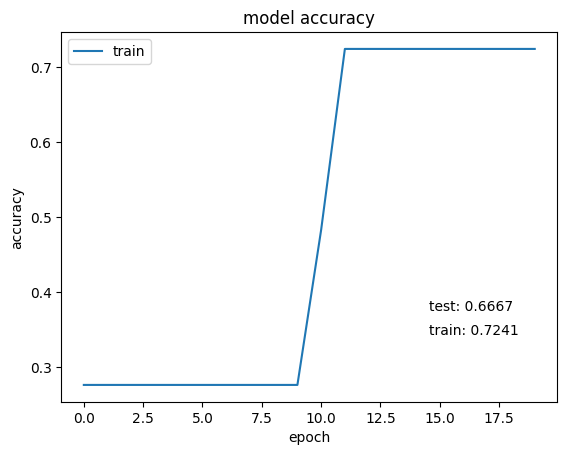

In [357]:
# Evaluate model on AAPL test set
print("EVALUATION ON TEST DATA of AAPL")
# Convert labels to one-hot encoding
Y_test_AAPL_encoded = to_categorical(Y_test_AAPL/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelAAPL.evaluate(X_test_AAPL, Y_test_AAPL_encoded)
# AAPL Graph
plt.plot(historyAAPL.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyAAPL.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

EVALUATION ON TEST DATA of AMZN
1/1 [==============================] - 1s 522ms/step - loss: 0.6862 - accuracy: 0.5833


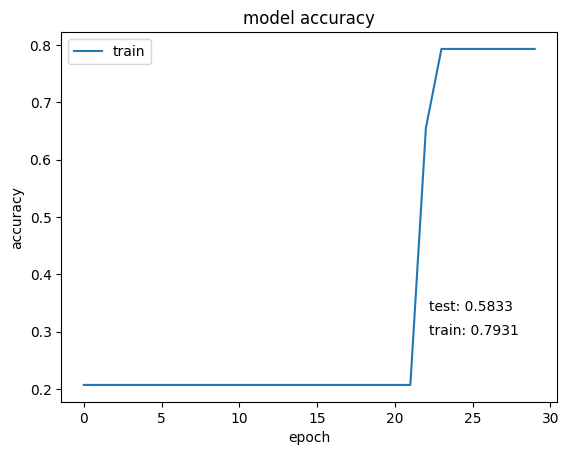

In [358]:
# Evaluate model on AMZN test set
print("EVALUATION ON TEST DATA of AMZN")
# Convert labels to one-hot encoding
Y_test_AMZN_encoded = to_categorical(Y_test_AMZN/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelAMZN.evaluate(X_test_AMZN, Y_test_AMZN_encoded)
# AMZN Graph
plt.plot(historyAMZN.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyAMZN.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

EVALUATION ON TEST DATA of TSLA
1/1 [==============================] - 1s 547ms/step - loss: 0.6907 - accuracy: 0.7500


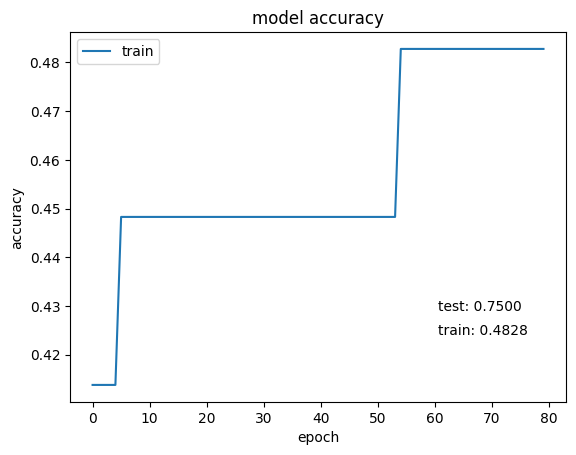

In [359]:
# Evaluate model on TSLA test set
print("EVALUATION ON TEST DATA of TSLA")
# Convert labels to one-hot encoding
Y_test_TSLA_encoded = to_categorical(Y_test_TSLA/2+1, num_classes=2) # /2+1 is to shift to range from -1,1 to 0,1 as wanted in keras
test_loss, test_acc = modelTSLA.evaluate(X_test_TSLA, Y_test_TSLA_encoded)
# TSLA Graph
plt.plot(historyTSLA.history['accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(historyTSLA.history['accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()